In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load image

(350, 450, 3)

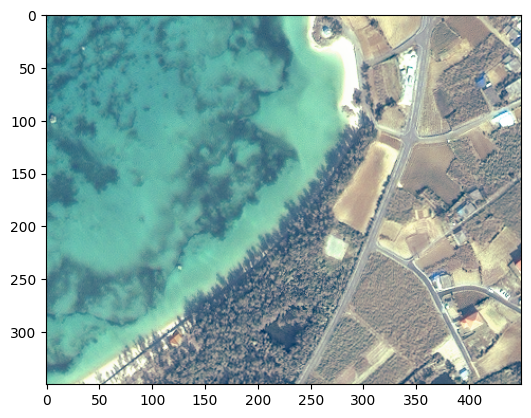

In [2]:
image = cv2.imread("irabu_zhang1.bmp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB
plt.imshow(image)
image.shape

# Step 1
Randomly select 10 points from each class as training data.
Use `point_sampler.py` file to get file `position.npy` and load it.

In [4]:
# Training points
pos_x = np.load("position.npy")

In [5]:
# Feature vector
x = image[pos_x[:, :, 1], pos_x[:, :, 0]]
x.shape

(5, 10, 3)

In [6]:
# Ground truth
y = np.array([[i] * 10 for i in range(5)])
y.shape, y

((5, 10),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]))

## Visualization

In [7]:
class_to_color = {
    0: (0, 255, 0),  # Class 1: Green
    1: (0, 0, 255),  # Class 2: Blue
    2: (255, 0, 0),  # Class 3: Red
    3: (255, 255, 0),  # Class 4: Yellow
    4: (0, 255, 255),  # Class 5: Cyan
}

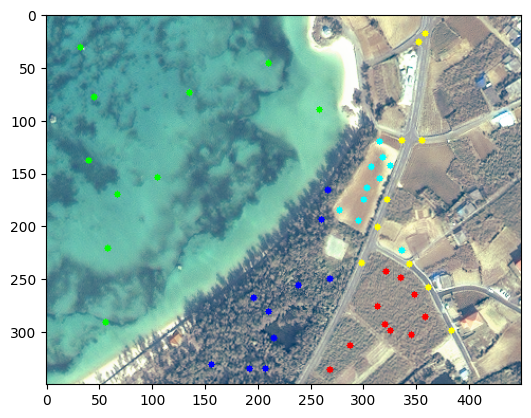

In [8]:
image_with_points = image.copy()
for class_id, points in enumerate(pos_x):
    for point in points:
        cv2.circle(image_with_points, tuple(point), 3, class_to_color[class_id], -1)
_ = plt.imshow(image_with_points)

# Step 2
Calculating mean vector $\mu_k$ and covariance matrix $\sum_k$ for each class using its training data $\bold{x}_k^n$

In [9]:
mean = np.mean(x, axis=1).T
mean  # (3, 5)

array([[ 92.5,  77.2, 144.6, 166.3, 204.5],
       [165.3, 102.9, 144. , 170.9, 190.8],
       [159.7, 120.7, 141.8, 169.6, 161.9]])

In [10]:
cov = np.stack([np.cov(x[class_id], rowvar=False) for class_id in range(5)])
cov.shape, cov

((5, 3, 3),
 array([[[ 616.27777778,  735.16666667,  386.61111111],
         [ 735.16666667,  979.34444444,  520.1       ],
         [ 386.61111111,  520.1       ,  280.01111111]],
 
        [[1130.84444444,  682.46666667,  424.84444444],
         [ 682.46666667,  418.54444444,  257.85555556],
         [ 424.84444444,  257.85555556,  164.9       ]],
 
        [[ 688.48888889,  408.55555556,  254.02222222],
         [ 408.55555556,  246.66666667,  153.77777778],
         [ 254.02222222,  153.77777778,   98.84444444]],
 
        [[ 497.34444444,  424.7       ,  205.57777778],
         [ 424.7       ,  375.21111111,  176.4       ],
         [ 205.57777778,  176.4       ,   91.82222222]],
 
        [[ 499.83333333,  649.44444444,  440.72222222],
         [ 649.44444444,  859.51111111,  572.2       ],
         [ 440.72222222,  572.2       ,  395.21111111]]]))

# Step 3
Calculate likelihood for each class

In [11]:
p_class = []
for class_id in range(5):
    _p1 = 1 / (np.power(2 * np.pi, 3 / 2) * np.sqrt(np.linalg.det(cov[class_id])))
    _p2 = np.exp(-0.5 * (image[..., None] - mean[:, class_id, None]).swapaxes(2, 3) @ np.linalg.inv(cov[class_id]) @ (image[..., None] - mean[:, class_id, None]))
    p_class.append(_p1 * _p2)

In [12]:
p_class = np.stack(p_class)
p_class = np.squeeze(p_class)
p_class.shape

(5, 350, 450)

# Step 4
Get class assignment for each pixel

In [13]:
class_img_2 = np.argmax(p_class, axis=0)

# Visualize final result

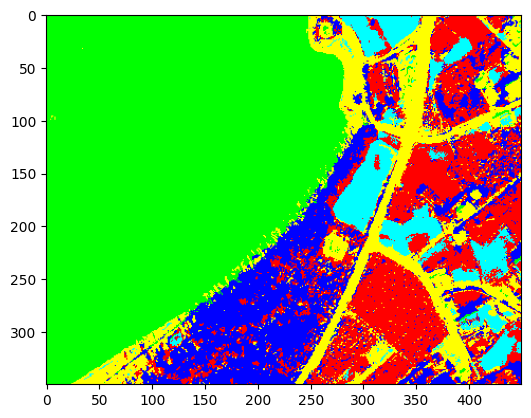

In [14]:
# Look-up table for quick color mapping
LUT = np.array([class_to_color[i] for i in range(5)], dtype=np.uint8)
segmented = LUT[class_img_2]
_ = plt.imshow(segmented)